In [1]:
import os
import math
from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input,Dropout,GlobalMaxPooling1D,MaxPooling1D,LSTM
from keras.metrics import categorical_accuracy

Using TensorFlow backend.


In [2]:
# Choose folder
folder = ['Amazon','FlipKart','Combine','Walmart']
class OpenData:
    def __init__(self,num):
        self.num = num
    def openFile(self):
        num = self.num
        trainData = pd.read_csv(folder[num]+'/X_train.csv')
        trainLabel = pd.read_csv(folder[num]+'/y_train.csv')
        testData = pd.read_csv(folder[num]+'/X_test.csv')
        testLabel = pd.read_csv(folder[num]+'/y_test.csv')
        if(num==0 or num==2):
            # For Description has nan row
            df = pd.concat([trainData,trainLabel], axis = 1)
            df = df.dropna(subset=['X_train'])
            trainData = pd.DataFrame({'X_train':df.X_train})
            trainLabel = pd.DataFrame({'category':df.category,'subcategory':df.subcategory})
            df = pd.concat([testData,testLabel], axis = 1)
            df = df.dropna(subset=['X_test'])
            testData = pd.DataFrame({'X_test':df.X_test})
            testLabel = pd.DataFrame({'category':df.category,'subcategory':df.subcategory})
        return trainData,trainLabel,testData,testLabel

In [28]:
class DLFeatureSelect:
    def __init__(self,train,trainLabel, test, testLabel, name):
        self.title = name
        self.X_train = trainData['X_train']
        self.X_test =  testData['X_test']
        self.y_train = trainLabel['category']
        self.y_test = testLabel['category']
        self.ynd_train = trainLabel['subcategory']
        self.ynd_test = testLabel['subcategory']
        self.target = np.unique(trainLabel['category'])
        self.outputnum = len(np.unique(trainLabel['category']))
        self.labels = to_categorical(trainLabel['category'])
        self.subtarget = np.unique(trainLabel['subcategory'])
        self.suboutputnum = len(np.unique(trainLabel['subcategory']))
        self.sublabels = to_categorical(trainLabel['subcategory'])

    def wordtoSequence(self):
        tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
        tfidfconverter.fit_transform(self.X_train)
        vocab_size = len(tfidfconverter.get_feature_names())
        print("Total vocabulary size: " +str(vocab_size)+'\n')
        self.vocabSize = vocab_size
        # Tranform Text to sequences   
        print("---- Word to sequence ---- \n")
        tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
        tokenizer.fit_on_texts(self.X_train)
        sequences = tokenizer.texts_to_sequences(self.X_train)
        sequences_test = tokenizer.texts_to_sequences(self.X_test)
        word_index = tokenizer.word_index
        print("Total unique words : " +str(len(word_index))+'\n')
        self.wordIndex = word_index
        return sequences,sequences_test
    def openGloveEmbeddingMatrix(self,dim):
        embedding_dim = dim 
        self.embeddingDim = embedding_dim
        print("---- Use "+ str(dim) +" dimension word vector ---- \n")

        glove_dir = '../glove.6B' # This is the folder with the dataset
        embeddings_index = {} # We create a dictionary of word -> embedding
        with open(os.path.join(glove_dir, 'glove.6B.'+str(dim)+'d.txt')) as f:
            for line in f:
                values = line.split()
                word = values[0] # The first value is the word, the rest are the values of the embedding
                embedding = np.asarray(values[1:], dtype='float32') # Load embedding
                embeddings_index[word] = embedding # Add embedding to our embedding dictionary
        print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))
        return embeddings_index
    def creatEmeddingMatrix(self,embeddings_index):
        word_index = self.wordIndex
        vocab_size = self.vocabSize
        embedding_dim = self.embeddingDim
        nb_words = min(vocab_size, len(word_index)) # How many words are there actually
        embedding_matrix = np.zeros((nb_words, embedding_dim))
        # The vectors need to be in the same position as their index. 
        # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
        # Loop over all words in the word index
        for word, i in word_index.items():
            # If we are above the amount of words we want to use we do nothing
            if i >= vocab_size: 
                continue
            # Get the embedding vector for the word
            embedding_vector = embeddings_index.get(word)
            # If there is an embedding vector, put it in the embedding matrix
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
        return embedding_matrix
    def model_settings(self,length,embeddingMatrix,outputnum,n):
        vocab_size = self.vocabSize
        embedding_dim = self.embeddingDim
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=length, weights = [embedding_matrix], 
                                trainable = False))
        model.add(Conv1D(n,3,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(GlobalMaxPooling1D())
        # We add a vanilla hidden layer:
        model.add(Dense(200))
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        return model
    def model_settingsnd(self,length,embeddingMatrix,outputnum,n):
        vocab_size = self.vocabSize
        embedding_dim = self.embeddingDim
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=length, weights = [embedding_matrix], 
                                trainable = False))
        model.add(Conv1D(n,5,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(MaxPooling1D(3))
        model.add(Conv1D(n,5,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(MaxPooling1D(3))
        model.add(Conv1D(n,5,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(MaxPooling1D(3))
        model.add(Flatten())
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        return model
    def model_settingsrd(self,length,embeddingMatrix,outputnum,n):
        vocab_size = self.vocabSize
        embedding_dim = self.embeddingDim
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=length, weights = [embedding_matrix], 
                                trainable = False))
        model.add(Dropout(0.25))
        model.add(Conv1D(n,5,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(MaxPooling1D(4))
        model.add(LSTM(70))
#         model.add(Flatten())
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        return model
    def creatmodel(self,sequences,sequences_test,embeddingMatrix,n):
        outputnum = self.outputnum
        X = pad_sequences(sequences,maxlen= 150)
        XTest = pad_sequences(sequences_test,maxlen = 150)
        y_train = self.labels
        y_test = self.y_test
        batch_size = 100
        epochs = 10
        model = self.model_settings(150,embeddingMatrix,outputnum,n)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
        history = model.fit(X, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
        loss, accuracy = model.evaluate(XTest, to_categorical(y_test))
        print("Accuracy: "+str(accuracy)+" Loss: "+str(loss)+"\n")
        return accuracy,loss
    
    
    def creatndmodel(self,sequences,sequences_test,embeddingMatrix,n):
        outputnum = self.outputnum
        X = pad_sequences(sequences,maxlen= 150)
        XTest = pad_sequences(sequences_test,maxlen = 150)
        y_train = self.labels
        y_test = self.y_test
        batch_size = 100
        epochs = 10
        model = self.model_settingsnd(150,embeddingMatrix,outputnum,n)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
        history = model.fit(X, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
        loss, accuracy = model.evaluate(XTest, to_categorical(y_test))
        print("Accuracy: "+str(accuracy)+" Loss: "+str(loss)+"\n")
        return accuracy,loss
    def creatrdmodel(self,sequences,sequences_test,embeddingMatrix,n):
        outputnum = self.outputnum
        X = pad_sequences(sequences,maxlen= 150)
        XTest = pad_sequences(sequences_test,maxlen = 150)
        y_train = self.labels
        y_test = self.y_test
        batch_size = 100
        epochs = 10
        model = self.model_settingsrd(150,embeddingMatrix,outputnum,n)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
        history = model.fit(X, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
        loss, accuracy = model.evaluate(XTest, to_categorical(y_test))
        print("Accuracy: "+str(accuracy)+" Loss: "+str(loss)+"\n")
        return accuracy,loss

In [4]:
openData = OpenData(0)
trainData,trainLabel,testData,testLabel = openData.openFile()


In [13]:
maps = [pow(2,ele) for ele in range(5,10)]
maps.append(100)
maps.append(200)
maps.append(300)
maps = np.sort(maps)
maps

array([ 32,  64, 100, 128, 200, 256, 300, 512])

In [29]:
dlFS = DLFeatureSelect(trainData,trainLabel,testData,testLabel,folder[0])
sequences,sequences_test =dlFS.wordtoSequence()
embeddings_index = dlFS.openGloveEmbeddingMatrix(300)
embedding_matrix = dlFS.creatEmeddingMatrix(embeddings_index)

Total vocabulary size: 5927

---- Word to sequence ---- 

Total unique words : 24058

---- Use 300 dimension word vector ---- 

Found 400,000 word vectors in GloVe.


In [30]:
acc1 = []
loss1 = []
for ele in maps:
    print("---- Number: "+ str(ele) + ' maps ------ \n')
    score, loss = dlFS.creatmodel(sequences,sequences_test,embedding_matrix, ele)
    acc1.append(score)
    loss1.append(loss)

---- Number: 32 maps ------ 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 150, 300)          1778100   
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 148, 32)           28832     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 200)               6600      
_________________________________________________________________
dropout_58 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 14)                2814      
Total params: 1,816,346
Trainable params: 38,246
Non-trainable params: 1,778,100
_______________________________

5219/5219 [==============================] - 2s 436us/step - loss: 0.0227 - categorical_accuracy: 0.9550 - val_loss: 0.0772 - val_categorical_accuracy: 0.8115
Epoch 7/10
5219/5219 [==============================] - 2s 434us/step - loss: 0.0174 - categorical_accuracy: 0.9703 - val_loss: 0.0806 - val_categorical_accuracy: 0.8130
Epoch 8/10
5219/5219 [==============================] - 2s 433us/step - loss: 0.0130 - categorical_accuracy: 0.9780 - val_loss: 0.0855 - val_categorical_accuracy: 0.8100
Epoch 9/10
5219/5219 [==============================] - 2s 428us/step - loss: 0.0126 - categorical_accuracy: 0.9805 - val_loss: 0.0892 - val_categorical_accuracy: 0.8038
Epoch 10/10
1633/1633 [==============================] - 0s 215us/step
Accuracy: 0.7721984078383344 Loss: 0.10016528509670383

---- Number: 128 maps ------ 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 150, 

5219/5219 [==============================] - 14s 3ms/step - loss: 0.1613 - categorical_accuracy: 0.5378 - val_loss: 0.0909 - val_categorical_accuracy: 0.7785
Epoch 2/10
5219/5219 [==============================] - 4s 776us/step - loss: 0.0758 - categorical_accuracy: 0.8113 - val_loss: 0.0760 - val_categorical_accuracy: 0.7977
Epoch 3/10
5219/5219 [==============================] - 4s 774us/step - loss: 0.0471 - categorical_accuracy: 0.8925 - val_loss: 0.0674 - val_categorical_accuracy: 0.8330
Epoch 4/10
5219/5219 [==============================] - 4s 775us/step - loss: 0.0293 - categorical_accuracy: 0.9381 - val_loss: 0.0683 - val_categorical_accuracy: 0.8322
Epoch 5/10
5219/5219 [==============================] - 4s 782us/step - loss: 0.0193 - categorical_accuracy: 0.9669 - val_loss: 0.0720 - val_categorical_accuracy: 0.8253
Epoch 6/10
5219/5219 [==============================] - 4s 779us/step - loss: 0.0142 - categorical_accuracy: 0.9776 - val_loss: 0.0710 - val_categorical_accuracy:

In [16]:
acc2 = []
loss2 = []
for ele in maps:
    print("---- Number: "+ str(ele) + ' maps ------ \n')
    score, loss = dlFS.creatndmodel(sequences,sequences_test,embedding_matrix, ele)
    acc2.append(score)
    loss2.append(loss)

---- Number: 32 maps ------ 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 150, 300)          1778100   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 146, 32)           48032     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 48, 32)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 44, 32)            5152      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 10, 32)            5152      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 3, 32)    

Train on 5219 samples, validate on 1305 samples
Epoch 1/10
5219/5219 [==============================] - 7s 1ms/step - loss: 0.2319 - categorical_accuracy: 0.2211 - val_loss: 0.2056 - val_categorical_accuracy: 0.3372
Epoch 2/10
5219/5219 [==============================] - 4s 701us/step - loss: 0.1923 - categorical_accuracy: 0.3677 - val_loss: 0.1768 - val_categorical_accuracy: 0.4215
Epoch 3/10
5219/5219 [==============================] - 4s 702us/step - loss: 0.1644 - categorical_accuracy: 0.4792 - val_loss: 0.1631 - val_categorical_accuracy: 0.4866
Epoch 4/10
5219/5219 [==============================] - 4s 705us/step - loss: 0.1460 - categorical_accuracy: 0.5434 - val_loss: 0.1589 - val_categorical_accuracy: 0.5149
Epoch 5/10
5219/5219 [==============================] - 4s 710us/step - loss: 0.1265 - categorical_accuracy: 0.6009 - val_loss: 0.1487 - val_categorical_accuracy: 0.5433
Epoch 6/10
5219/5219 [==============================] - 4s 710us/step - loss: 0.1144 - categorical_accur

5219/5219 [==============================] - 6s 1ms/step - loss: 0.0962 - categorical_accuracy: 0.6871 - val_loss: 0.1640 - val_categorical_accuracy: 0.5579
Epoch 8/10
5219/5219 [==============================] - 6s 1ms/step - loss: 0.0885 - categorical_accuracy: 0.7068 - val_loss: 0.1632 - val_categorical_accuracy: 0.5540
Epoch 9/10
5219/5219 [==============================] - 6s 1ms/step - loss: 0.0886 - categorical_accuracy: 0.7088 - val_loss: 0.1709 - val_categorical_accuracy: 0.5640
Epoch 10/10
1633/1633 [==============================] - 1s 508us/step
Accuracy: 0.5223515003061849 Loss: 0.20214883739798678

---- Number: 256 maps ------ 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 150, 300)          1778100   
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 146, 256)          384256    
___________________

Train on 5219 samples, validate on 1305 samples
Epoch 1/10
5219/5219 [==============================] - 30s 6ms/step - loss: 0.2561 - categorical_accuracy: 0.1544 - val_loss: 0.2264 - val_categorical_accuracy: 0.2521
Epoch 2/10
5219/5219 [==============================] - 26s 5ms/step - loss: 0.2089 - categorical_accuracy: 0.2899 - val_loss: 0.1889 - val_categorical_accuracy: 0.3793
Epoch 3/10
5219/5219 [==============================] - 26s 5ms/step - loss: 0.1775 - categorical_accuracy: 0.4261 - val_loss: 0.1671 - val_categorical_accuracy: 0.4713
Epoch 4/10
5219/5219 [==============================] - 26s 5ms/step - loss: 0.1513 - categorical_accuracy: 0.5191 - val_loss: 0.1563 - val_categorical_accuracy: 0.5096
Epoch 5/10
5219/5219 [==============================] - 26s 5ms/step - loss: 0.1304 - categorical_accuracy: 0.5856 - val_loss: 0.1531 - val_categorical_accuracy: 0.5326
Epoch 6/10
5219/5219 [==============================] - 26s 5ms/step - loss: 0.1141 - categorical_accuracy:

In [18]:
acc3 = []
loss3 = []
for ele in maps:
    print("---- Number: "+ str(ele) + ' maps ------ \n')
    score, loss = dlFS.creatrdmodel(sequences,sequences_test,embedding_matrix, ele)
    acc3.append(score)
    loss3.append(loss)

---- Number: 32 maps ------ 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 150, 300)          1778100   
_________________________________________________________________
dropout_42 (Dropout)         (None, 150, 300)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 146, 32)           48032     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 36, 32)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 70)                28840     
_________________________________________________________________
dropout_43 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 14)       

5219/5219 [==============================] - 5s 1ms/step - loss: 0.1025 - categorical_accuracy: 0.7203 - val_loss: 0.1018 - val_categorical_accuracy: 0.7195
Epoch 5/10
5219/5219 [==============================] - 5s 1ms/step - loss: 0.0902 - categorical_accuracy: 0.7605 - val_loss: 0.0949 - val_categorical_accuracy: 0.7517
Epoch 6/10
5219/5219 [==============================] - 5s 1ms/step - loss: 0.0800 - categorical_accuracy: 0.7844 - val_loss: 0.0943 - val_categorical_accuracy: 0.7533
Epoch 7/10
5219/5219 [==============================] - 5s 1ms/step - loss: 0.0731 - categorical_accuracy: 0.8078 - val_loss: 0.0887 - val_categorical_accuracy: 0.7670
Epoch 8/10
5219/5219 [==============================] - 5s 1ms/step - loss: 0.0666 - categorical_accuracy: 0.8249 - val_loss: 0.0913 - val_categorical_accuracy: 0.7548
Epoch 9/10
5219/5219 [==============================] - 5s 1ms/step - loss: 0.0645 - categorical_accuracy: 0.8268 - val_loss: 0.0890 - val_categorical_accuracy: 0.7617
Epo

Train on 5219 samples, validate on 1305 samples
Epoch 1/10
5219/5219 [==============================] - 17s 3ms/step - loss: 0.1867 - categorical_accuracy: 0.4380 - val_loss: 0.1274 - val_categorical_accuracy: 0.6628
Epoch 2/10
5219/5219 [==============================] - 9s 2ms/step - loss: 0.1233 - categorical_accuracy: 0.6658 - val_loss: 0.1083 - val_categorical_accuracy: 0.7172
Epoch 3/10
5219/5219 [==============================] - 9s 2ms/step - loss: 0.1033 - categorical_accuracy: 0.7208 - val_loss: 0.0983 - val_categorical_accuracy: 0.7341
Epoch 4/10
5219/5219 [==============================] - 9s 2ms/step - loss: 0.0882 - categorical_accuracy: 0.7651 - val_loss: 0.0912 - val_categorical_accuracy: 0.7471
Epoch 5/10
5219/5219 [==============================] - 8s 2ms/step - loss: 0.0745 - categorical_accuracy: 0.7975 - val_loss: 0.0884 - val_categorical_accuracy: 0.7525
Epoch 6/10
5219/5219 [==============================] - 9s 2ms/step - loss: 0.0686 - categorical_accuracy: 0.82

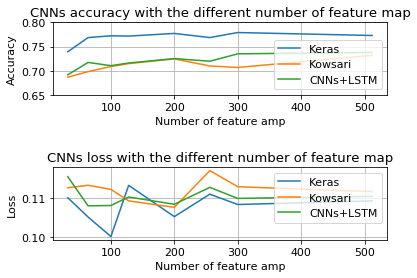

In [32]:
plt.rcParams.update({'font.size': 11})



fig, ax = plt.subplots(2, 1)
fig.subplots_adjust(hspace=1)

ax[0].plot(maps, acc1, label="Keras")
ax[0].plot(maps, acc2, label="Kowsari")
ax[0].plot(maps, acc3, label="CNNs+LSTM")
ax[0].set_xlabel("Number of feature amp")
ax[0].set_ylabel("Accuracy")
ax[0].yaxis.set_ticks(np.arange(0.65,0.8,0.05))


title= "CNNs accuracy with the different number of feature map"
ax[0].set_title(title)

ax[1].plot(maps, loss1, label="Keras")
ax[1].plot(maps, loss2, label="Kowsari")
ax[1].plot(maps, loss3, label="CNNs+LSTM")
ax[1].set_xlabel("Number of feature amp")
ax[1].set_ylabel("Loss")


title2= "CNNs loss with the different number of feature map"
ax[1].set_title(title2)
ax[0].grid()
ax[0].legend()
ax[1].grid()
ax[1].legend()

fig.savefig('CNN_para.png', bbox_inches='tight')
